# Check Bounding Boxex NIH

In [1]:
import os
import glob
import pandas as pd
import xml.etree.ElementTree as ET
from os import listdir
from os.path import isfile, join
import sys
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.colors as colors
import numpy as np
from ftplib import FTP
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from matplotlib import pyplot
from shapely.geometry.polygon import LinearRing, Polygon
sys.path.insert(0, os.path.dirname(os.path.abspath('.'))) # to make imports relative to project root work

First download files from ftp://lhcftp.nlm.nih.gov/Open-Access-Datasets/Malaria/NIH-NLM-ThinBloodSmearsPf/ to folder e.g.

NIH_NLM_ThinBloodSmears <br>
└-Point Set <br>
└-Polygon Set <br>
Notebooks <br>
└-IH_bounding_boxes.ipynb <br>

wget -r -np  ftp://gdo152.ucllnl.org/cowc/datasets/ground_truth_sets


In [2]:
# Point
img_path = '../NIH-NLM-ThinBloodSmearsPf/' + 'Point Set/' + '380C241NThinF/' + 'Img/' + 'IMG_20151207_124358.jpg'
gt_path = '../NIH-NLM-ThinBloodSmearsPf/' + 'Point Set/' + '380C241NThinF/' + 'GT/' + 'IMG_20151207_124358.txt'

# Polygon
img_path = '../NIH-NLM-ThinBloodSmearsPf/' + 'Polygon Set/' + '142C38P3thinF_original/' + 'Img/' + 'IMG_20150621_112023.jpg'
gt_path = '../NIH-NLM-ThinBloodSmearsPf/' + 'Polygon Set/' + '142C38P3thinF_original/' + 'GT/' + 'IMG_20150621_112023.txt'

../NIH-NLM-ThinBloodSmearsPf/Polygon Set/142C38P3thinF_original/Img/IMG_20150621_112023.jpg


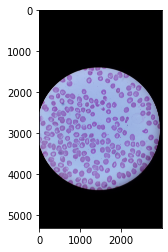

In [3]:
img = cv2.imread(img_path, cv2.IMREAD_COLOR)
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
# img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img = cv2.flip(img, 1)
print(img_path)
plt.imshow(img)

In [4]:
# Delimiter
data_file_delimiter = ','
df = pd.DataFrame(columns = [ '?','cell', 'comment', 'annotation_type','??', 'position'])

In [5]:
# Loop the data lines
with open(gt_path, 'r') as temp_f:
    # Read the lines
    lines = temp_f.readlines()

    for l in lines[1:]:
        # Count the column count for the current line
        columns = l.split(data_file_delimiter)
        list_locations = []
        for location in columns[5:]:
            list_locations.append(int(float(location)))
        zip_locations = list(zip(list_locations[1::2], list_locations[::2]))
        df = df.append( {'?': columns[0], 'cell': columns[1], 'comment': columns[2], 'annotation_type': columns[3],'??': columns[4], 'position': zip_locations}, ignore_index = True)
df

,?,cell,comment,annotation_type,??,position
0,1-191,Uninfected,No_comment,Polygon,11,"[(1707, 2414), (1669, 2416), (1646, 2431), (16..."
1,1-192,Uninfected,No_comment,Polygon,12,"[(1714, 2247), (1676, 2259), (1647, 2278), (16..."
2,1-193,Uninfected,No_comment,Polygon,11,"[(1821, 2233), (1788, 2259), (1773, 2307), (17..."
3,1-194,Uninfected,No_comment,Polygon,11,"[(1715, 2618), (1679, 2615), (1645, 2634), (16..."
4,1-195,Uninfected,No_comment,Polygon,12,"[(1852, 2597), (1807, 2608), (1784, 2636), (17..."
...,...,...,...,...,...,...
372,1-95,Uninfected,No_Comment,Point,1,"[(1138, 2148)]"
373,1-96,Uninfected,No_Comment,Point,1,"[(1246, 2200)]"
374,1-97,Uninfected,No_Comment,Point,1,"[(1374, 2218)]"
375,1-98,Uninfected,No_Comment,Point,1,"[(1089, 1984)]"


In [6]:
# df = pd.read_csv(gt_path, sep = ',', header = 0, names= [ '?','cell', 'comment', 'annotation_type','??', 'y', 'x'])
df['cell'].value_counts()

Uninfected    377
Name: cell, dtype: int64

In [7]:
def rgb_to_hex(rgb):
    return '%02x%02x%02x' % rgb

def draw_points(img, cell, annotation, position):
    colour = (0,255,0) if cell == 'Uninfected' \
        else (255,0, 0) if cell == 'Parasitized' \
            else (128,0, 128) if cell == 'Platelet' \
                else (0, 0, 255) if cell == 'White_Blood_Cell' \
                    else (255,215,0)
                    
    if annotation == 'Point':
        cv2.circle(img, position[0], 1, colour, 15)
    
    elif annotation == 'Polygon':
        poly = Polygon(position)
        x,y = poly.exterior.xy
        ax = fig.add_subplot(111)
        ax.plot(x, y, color=rgb_to_hex(colour), alpha=0.7,
            linewidth=3, solid_capstyle='round', zorder=2)

In [8]:
def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb
rgb_to_hex((255,215,0))

'#ffd700'

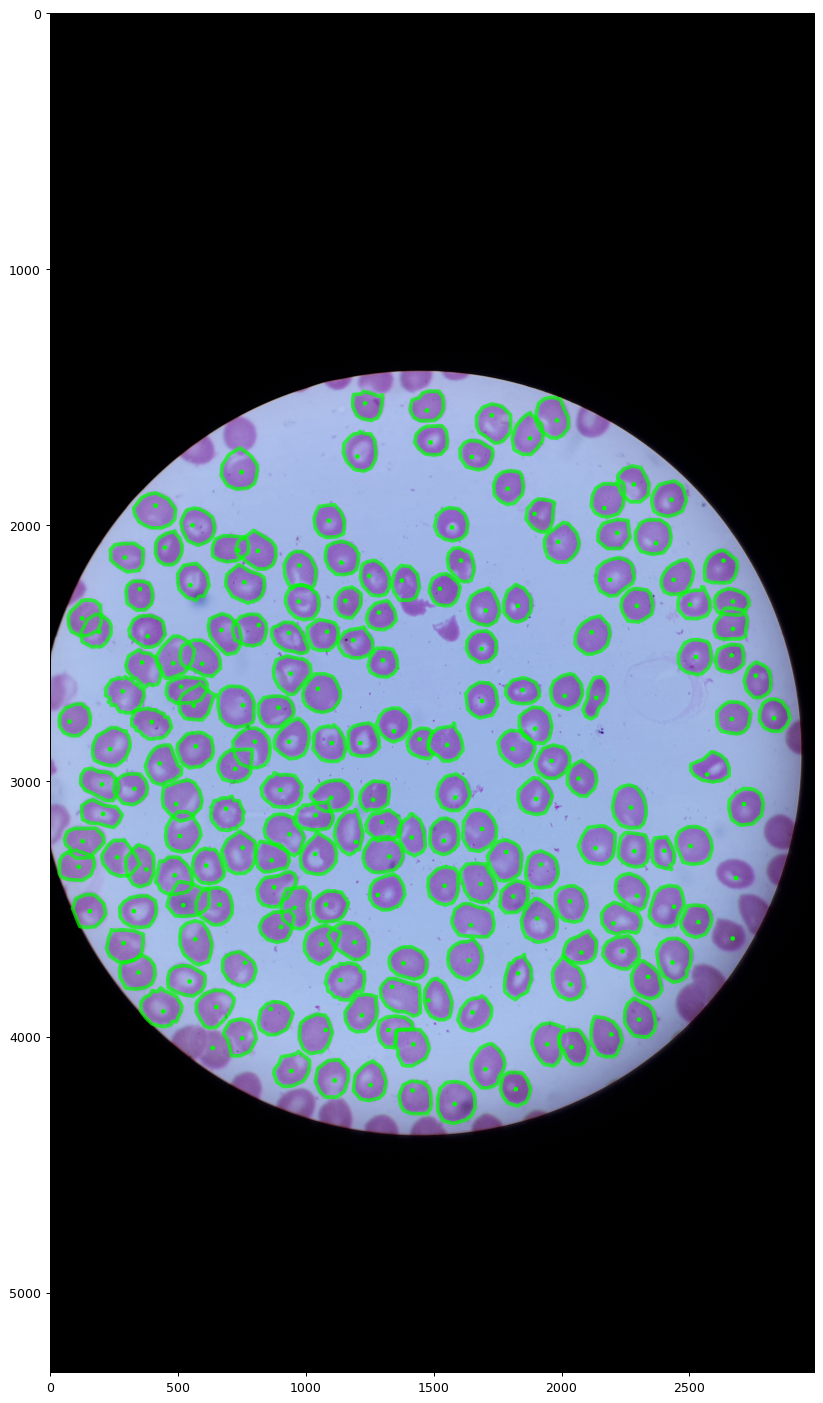

In [9]:
fig = plt.figure(1, figsize=(20,20), dpi=90)
df.apply(lambda row: draw_points(img, row['cell'], row['annotation_type'], row['position']), axis = 1)
plt.imshow(img)
